# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [ ]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [ ]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

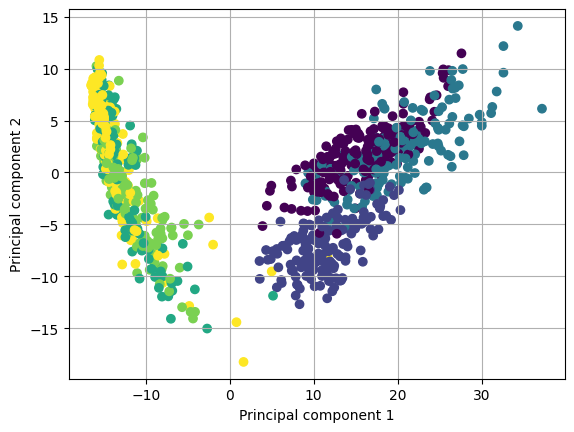

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

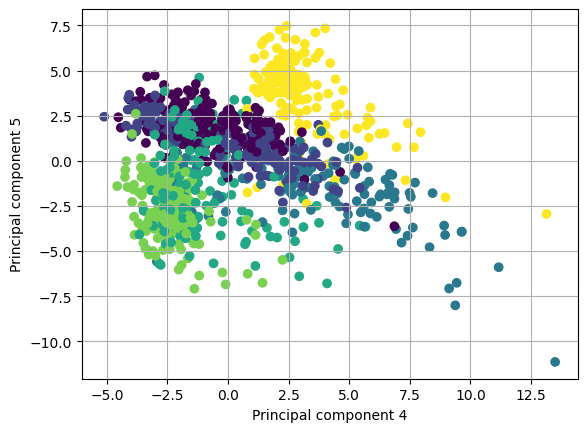

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [ ]:
# pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import optuna

In [ ]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
n_estimators=165
learning_rate=0.1
depth=5

In [ ]:
model = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=depth,
    learning_rate=learning_rate,
)

In [ ]:
model.fit(X_train_pca, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"f1 = {f1:.4f} for iterations = {n_estimators}, max_depth = {depth}, learning_rate = {learning_rate}")

f1 = 0.9123 for iterations = 150, max_depth = 5, learning_rate = 0.1


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/) or [hyperopt](http://hyperopt.github.io/hyperopt/) zero order optimizer to find optimal hyper param set.

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 180),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1)
    }

    model = XGBClassifier(
        **params,
        verbosity=0,
        use_label_encoder=True,
        eval_metric="mlogloss"
    )
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=900)

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)

[I 2024-12-08 19:37:44,477] A new study created in memory with name: no-name-3b9504f2-6d79-4565-bba3-9021f600f39d
[I 2024-12-08 19:39:07,580] Trial 0 finished with value: 0.8948609268972856 and parameters: {'n_estimators': 155, 'max_depth': 10, 'learning_rate': 0.0783858994581933}. Best is trial 0 with value: 0.8948609268972856.
[I 2024-12-08 19:40:13,998] Trial 1 finished with value: 0.9010549629812239 and parameters: {'n_estimators': 178, 'max_depth': 9, 'learning_rate': 0.09281130169481992}. Best is trial 1 with value: 0.9010549629812239.
[I 2024-12-08 19:41:30,222] Trial 2 finished with value: 0.8975304095388037 and parameters: {'n_estimators': 174, 'max_depth': 10, 'learning_rate': 0.08068646361728268}. Best is trial 1 with value: 0.9010549629812239.
[I 2024-12-08 19:42:10,834] Trial 3 finished with value: 0.9042001415814994 and parameters: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.06501467039401869}. Best is trial 3 with value: 0.9042001415814994.
[I 2024-12-08 19:

Best parameters: {'n_estimators': 173, 'max_depth': 4, 'learning_rate': 0.09937100701631402}
Best F1 score: 0.9147219138539766


In [ ]:
best_iter = study.best_params['n_estimators']
best_depth = study.best_params['max_depth']
best_rate = study.best_params['learning_rate']

best_model = best_model = XGBClassifier(
    n_estimators=best_iter,
    max_depth=best_depth,
    learning_rate=best_rate,
)

best_model.fit(X_train_pca, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09937100701631402,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=173, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = best_model.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"The best value of f1 = {f1:.4f} for iterations = {best_iter}, max_depth = {best_depth}, learning_rate = {best_rate}")

The best value of f1 = 0.9147 for iterations = 173, max_depth = 4, learning_rate = 0.09937100701631402


### Conclusion
С помощью Optuna получили гиперпараметры, при которых значение метрики f1 чуть больше, чем при гиперпараметрах, подобранных в ручную.

## Part 3. Interpret the model predictions

Train model on original feature set and analyze it.

Please use [shap](https://github.com/slundberg/shap) to build beeswarm plot and at least one of your choice and interpret them (write conclusion).

Explanations of features can be found on dataset's UCI page (see dataset downloading section).

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
n_estimators=165
learning_rate=0.1
depth=5

In [ ]:
model = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=depth,
    learning_rate=learning_rate,
)

In [ ]:
model.fit(X_train_unique, y_train, verbose=False)
y_pred = model.predict(X_test_unique)

In [ ]:
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Value of f1 = {f1:.4f} on original feature set")

Value of f1 = 0.9340 on original feature set


In [ ]:
explainer = shap.Explainer(model, X_train_unique)
shap_values = explainer(X_test_unique)

100%|===================| 17678/17682 [08:16<00:00]       

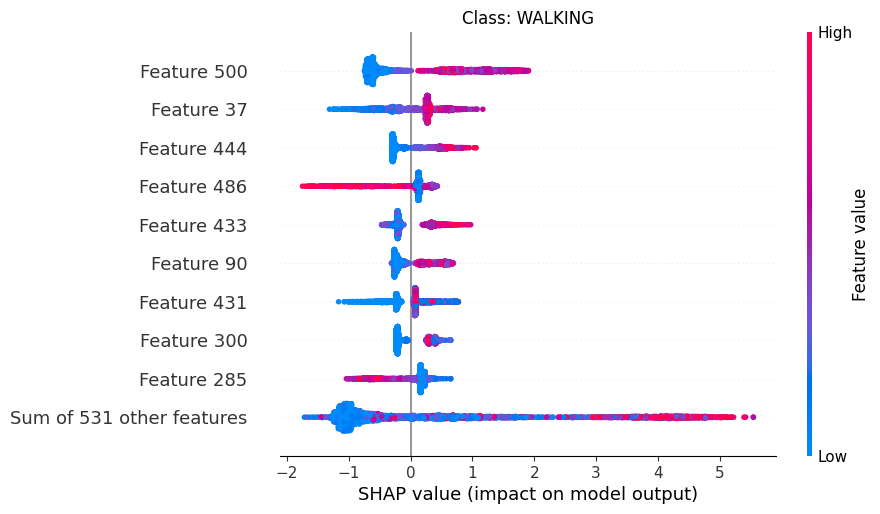

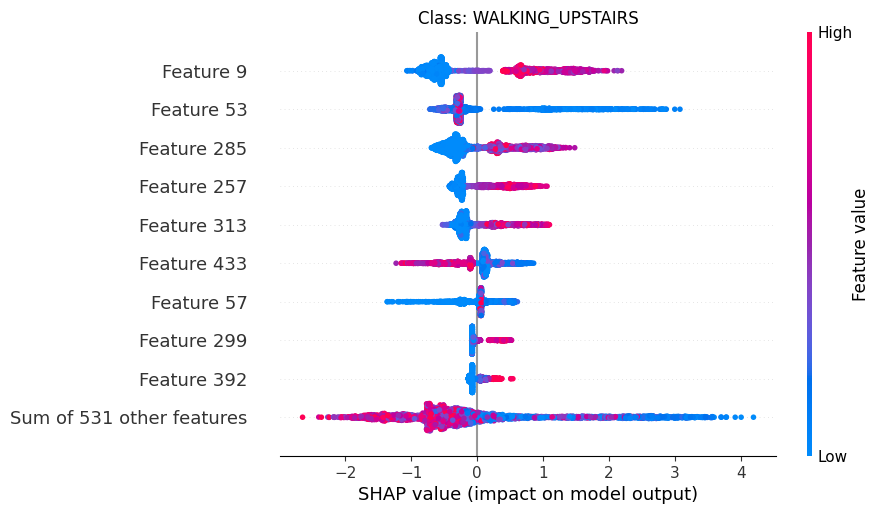

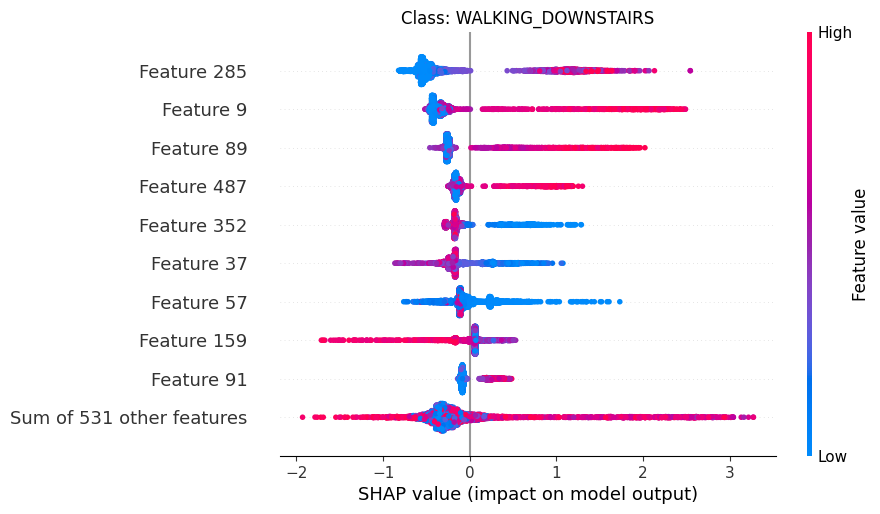

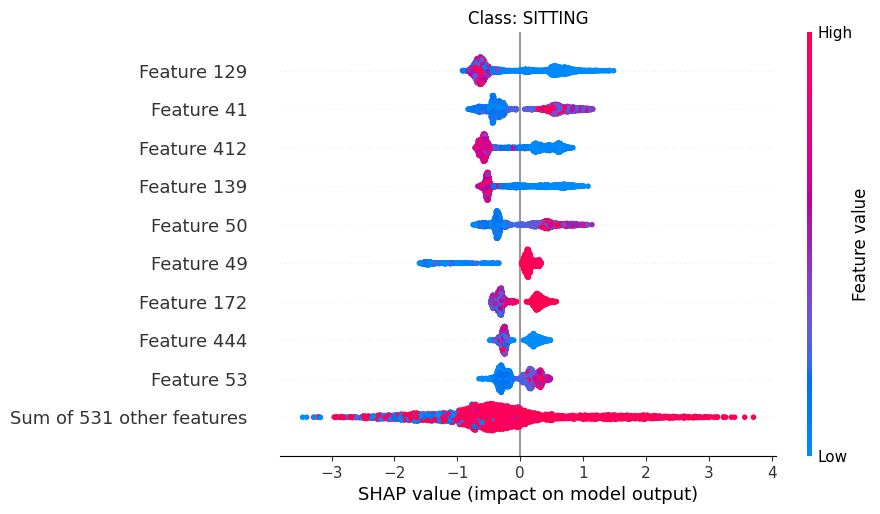

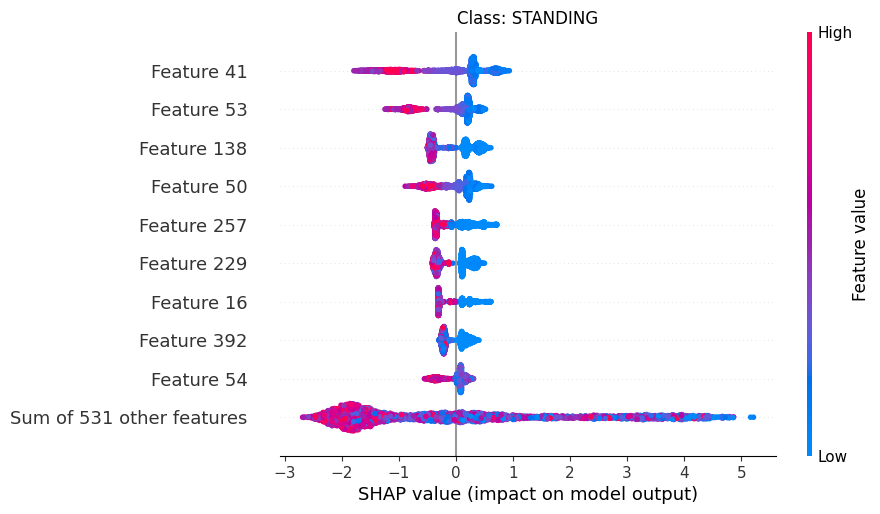

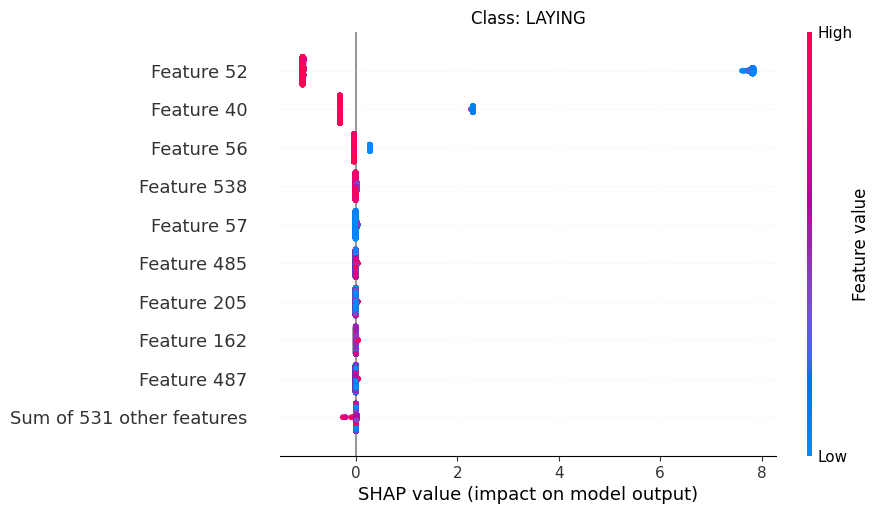

In [ ]:
for i, class_name in activity_labels.items():
    ax = shap.plots.beeswarm(shap_values[..., i - 1], show=False)
    ax.set_title(f"Class: {class_name}")
    plt.show()

### Conclusion

Рассмотрим Feature 37. Для walking_downstairs низкие значения этой фичи оказывают положительное влияние на таргет, а высокие -- отрицательное. Для walking ситуация обратная: высокие значения этой фичи оказывают положительное влияние на таргет, а низкие значения оказывают отрицательное влияние на таргет.